In this notebook, we are going through a style transfer example.

Some of the code is taken from [udacity's deep learning nanodegree's style transfer notebook](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/style-transfer/Style_Transfer_Solution.ipynb)

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import torch
import torch.optim as optim
from torchvision import models

from helper import load_image, image_tensor_to_numpy, get_features, get_gram_matrix

# Style Transfer

To transfer a style image's style to a content image, we need to

- initialize target image with a clone of content image
- iteratively update the target image to minimize content loss and style loss (so that we can keep dolly's face and start to apply style from monument valley)

## Style and Content Images

The content image we'll be using is an image of [Dolly](https://en.wikipedia.org/wiki/Dolly_(sheep)), the first mammal cloned from an adult somatic cell.  

On top of the content image, we'll apply the style from [*Monument Valley*](https://en.wikipedia.org/wiki/Monument_Valley_(video_game)), which is a super asthetically pleasing puzzle solving game.

And the idea is inspired by the novel [*Do Androids Dream of Electric Sheep?*](https://en.wikipedia.org/wiki/Do_Androids_Dream_of_Electric_Sheep%3F)

Okay, let's first take a look at our input images

In [2]:
# ! mkdir images
! ls images

Dolly_face_closeup.jpg	monument_valley.jpg  monument_valley_resized.jpg


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
content = load_image('images/Dolly_face_closeup.jpg').to(device)
style = load_image('images/monument_valley_resized.jpg').to(device)

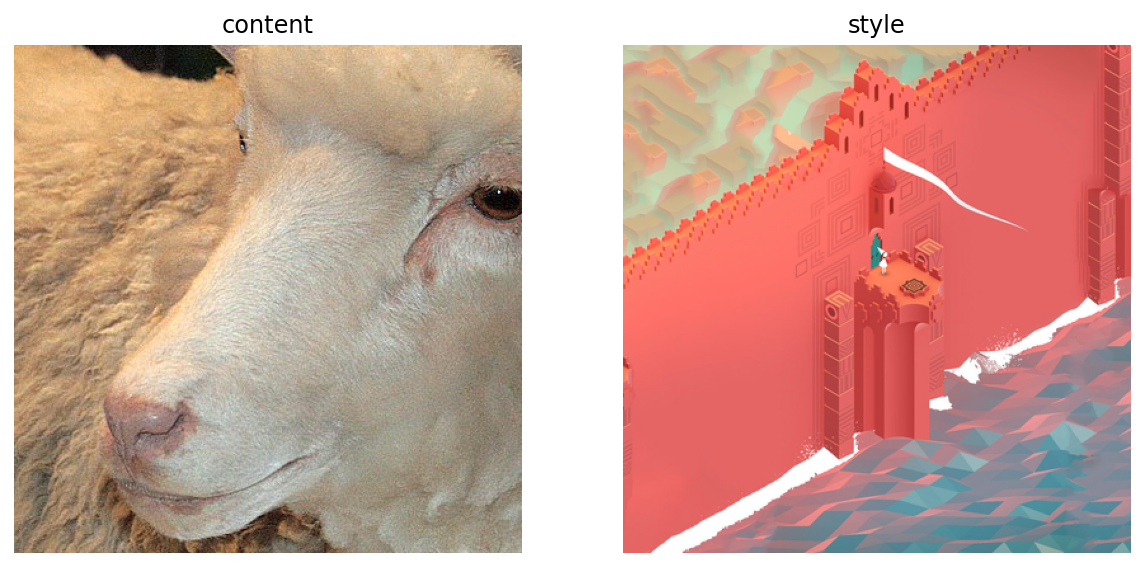

In [5]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(image_tensor_to_numpy(content))
ax[0].axis('off');
ax[0].set_title('content')
ax[1].imshow(image_tensor_to_numpy(style))
ax[1].set_title('style')
ax[1].axis('off');

Next, we will look into the loss function

# Content Loss

**Notations**: 

- $T_c$, content representation of the target image.

- $C_c$, content representation of the content image.
- $N_c$, numel (total elements) of the content representation tensor

The content representation is obtained by forwarding input image up until layer 21 of vgg19.features, which is referred as conv4_2 (the 2nd convolution layer in the 4th convolution stack)

The content loss is calculated by taking the mean squared error of $T_c$ (relative to $C_c$)

$$\mathcal{L}_{\text{content}} = \frac{1}{N_c}(T_c - C_c)^2$$

# Style Loss

**Notations**: 

$i \in I$, a subset of convolution layer in vgg19

$T_{s, i}$, gram matrix of target image at layer $i$

$S_{s, i}$, gram matrix of style image at layer $i$

$d_i$, depth of feature maps at layer $i$

$h_i$, heigh of feature maps at layer $i$

$w_i$, width of feature maps at layer $i$

$N_{s, i}$, numel (total elements) of gram matrix at layer $i$, equals to $d_i*d_i$

$\omega_i$, weight of style gram loss at layer $i$



To calculate the gram matrix of an image at layer $i$, we forward the input image up to layer $i$ to obtain the feature maps of shape (depth, height, width). The stack of feature maps is then transformed to shape (depth, height * weight), and multiplied by its transpose. The gram matrix is of shape (depth, depth), and is an indication of correlations among feature maps (in the same layer).

The style error is calculated by taking the weighted sum of the mean squared error of the target image's style gram (relative to the style image's style gram) at different layers. Since the depth, height and width are different among the layers that we are calculating the gram matrix for, we also want to normalize the gram. See [details](https://github.com/udacity/deep-learning-v2-pytorch/issues/174#issuecomment-562832819).



$$\mathcal{L}_{\text{style}} = \sum_{i \in I} \omega_i * \frac{1}{N_{s, i}}(T_{s,i} - S_{s, i})^2 \frac{1}{h_i^2 * w_i^2}$$


# Total Loss

**Notations**:

$\alpha$, content loss weight
$\beta$, style loss weight

$$\mathcal{L}_{\text{total}} = \alpha * \mathcal{L}_{\text{content}} + \beta * \mathcal{L}_{\text{style}}$$

Now that we know how is the loss defined, we are ready to iteratively update our target image.

First, we'll to load the pretrained vgg19. 

Since we are not using it for classification, we only need the feature extracting part, and should also set the weights' `require_grad` attribute to `False`

In [6]:
vgg = models.vgg19(pretrained=True).features

In [7]:
for param in vgg.parameters():
  param.requires_grad = False

In [8]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Then, we need to obtain,

- the content image's features from the following layers of vgg19.feature
  ```
  {'0': 'conv1_1', 
   '5': 'conv2_1',
   '10':'conv3_1',
   '19':'conv4_1',
   '21':'conv4_2', 
   '28':'conv5_1'}
  ```
- the style image's features from the above layers
- the style image's gram matrices from the above layers (except for `conv4_2`)

The functions used to obtain feature and gram matrix are included in the `helper.py` file

In [9]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [10]:
style_grams = {
    name: get_gram_matrix(feature) 
    for name, feature in style_features.items() if name != 'conv4_2'}

We also need to set up the style weights of the 1st convolution layer of each convolution stack. 

We will give early convolution layers a higher weight.


In [11]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

To make our target stylistic, we give the content loss a small weight of 1, and the style loss a large weight of 1e6. 

The smaller the content weight to style weight ratio, the more stylistic our target image is going to be.

In [12]:
content_loss_weight = 1  
style_loss_weight = 1e6

In the next few code blocks, we will

- initialize the target image with a clone of the content image
- set up an optimizer
- iterative update the target image tensor to minimize loss function

In [13]:
target = content.clone().requires_grad_(True).to(device)

In [14]:
optimizer = optim.Adam([target], lr=0.005)

Iter: 500, Total loss:  218692.53125


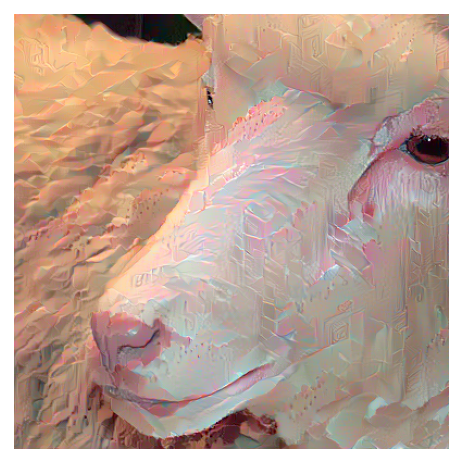

Iter: 1000, Total loss:  113849.0625


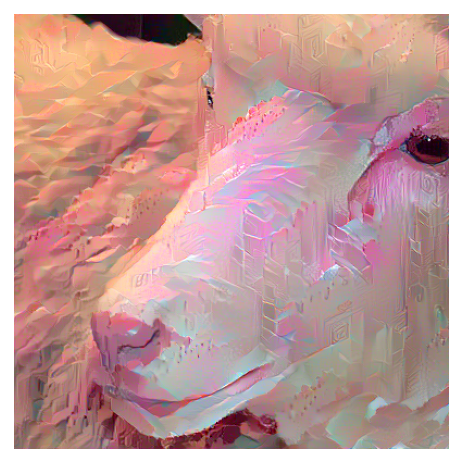

Iter: 1500, Total loss:  68917.8125


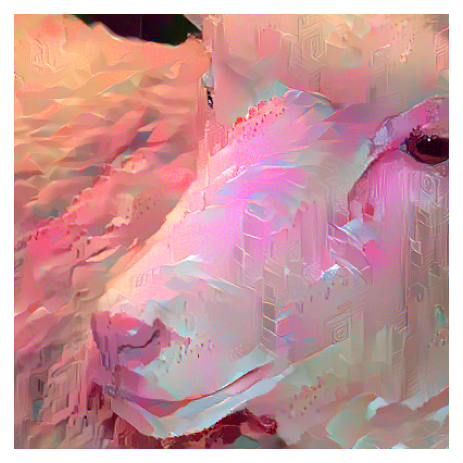

Iter: 2000, Total loss:  49104.69140625


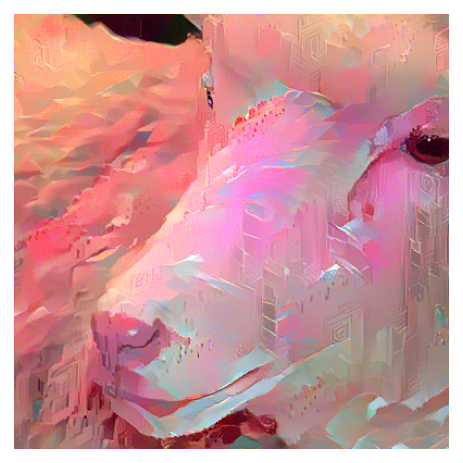

Iter: 2500, Total loss:  37221.1484375


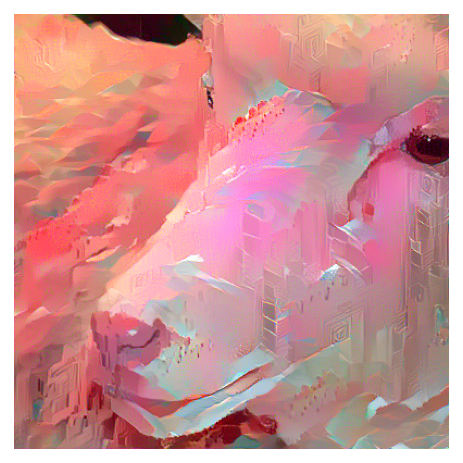

Iter: 3000, Total loss:  30036.6796875


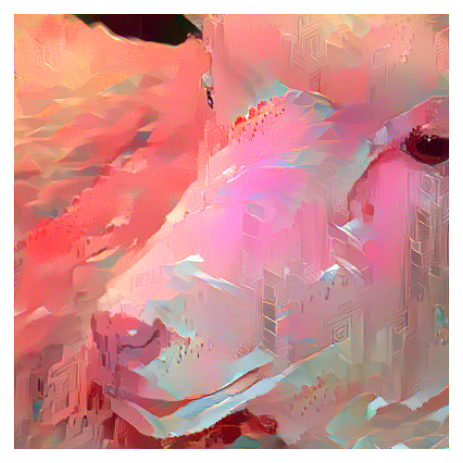

In [15]:
num_iterations = 3000

for i in range(1, num_iterations+1):
  # recalculate target features
  target_features = get_features(target, vgg)
  
  content_loss = torch.mean((content_features['conv4_2'] - target_features['conv4_2']) ** 2)
  style_loss = 0

  for layer, weight in style_weights.items():
    target_feature = target_features[layer]
    _, _, h, w = target_feature.shape
    # target_gram and style_gram is of shape (d, d)
    target_gram = get_gram_matrix(target_feature)
    style_gram = style_grams[layer]
    # loss is avg'd over (d * d) elements
    layer_style_loss = torch.mean((style_gram - target_gram) ** 2)
    # weight and normalize the layer loss
    style_loss += weight * layer_style_loss / (h ** 2 * w ** 2)
  
  total_loss = content_loss_weight * content_loss + style_loss_weight * style_loss

  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if i % 500 == 0:
    print(f'Iter: {i}, Total loss: ', total_loss.item())
    plt.imshow(image_tensor_to_numpy(target))
    plt.axis('off')
    plt.show()


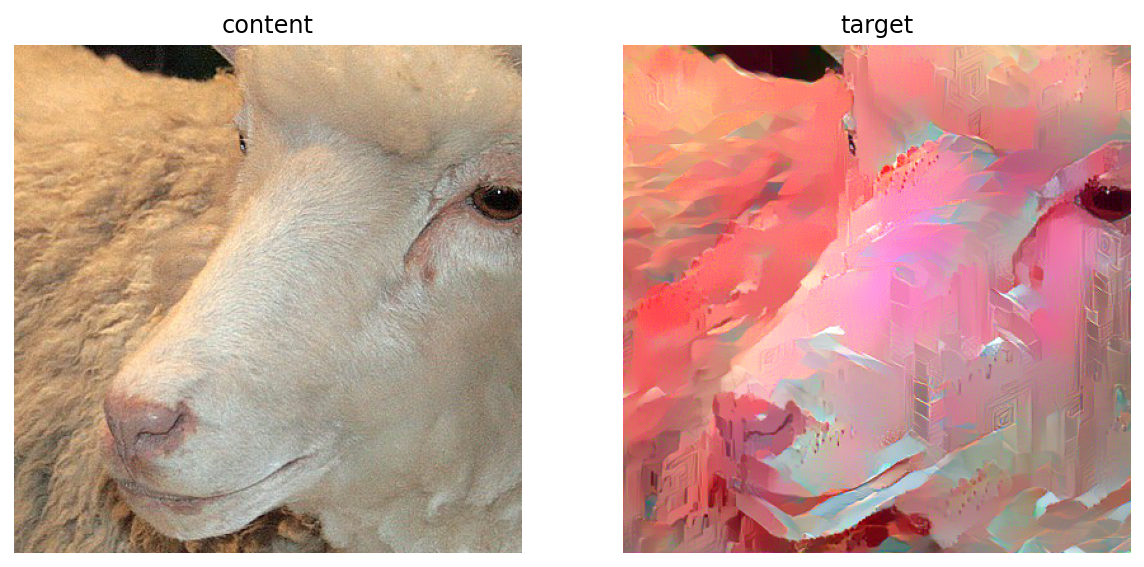

In [16]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(image_tensor_to_numpy(content))
ax[0].axis('off');
ax[0].set_title('content')
ax[1].imshow(image_tensor_to_numpy(target))
ax[1].set_title('target')
ax[1].axis('off');

In [17]:
torch.save(target.to('cpu'), 'an_androids_dream_of_electric_sheep.pt')